In [1]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [2]:
import glob

In [3]:
from pydub import AudioSegment

# 人声去除

目标:从一段音频中去除人声

## 人声读取

### 位置

利用glob获取每一个data的位置

In [4]:
voiceset = L(glob.glob('../dataset/dataset/voice_dataset/cv-corpus-11.0-delta-2022-09-21/en/clips/*.mp3'))

In [5]:
voiceset[0]

'../dataset/dataset/voice_dataset/cv-corpus-11.0-delta-2022-09-21/en/clips/common_voice_en_34451548.mp3'

### 读取

使用pydub读取声音

In [6]:
mp3 = AudioSegment.from_mp3(voiceset[0])

In [7]:
mp3

读取成功

### 转换

In [8]:
arr = np.frombuffer(mp3.raw_data, dtype='int16')

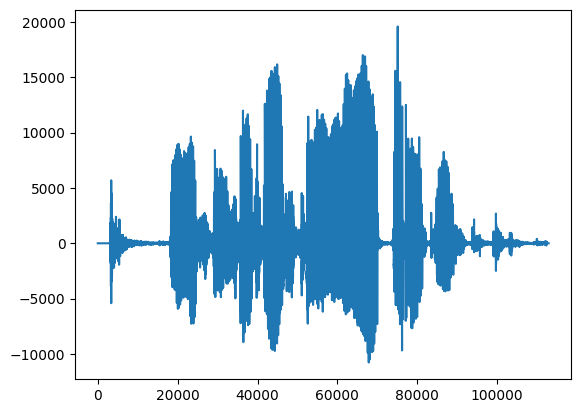

In [9]:
plt.plot(np.arange(len(arr)),arr)

In [10]:
mp3.frame_rate

32000

### 组合

In [89]:
def getmp3raw(path):
    mp3 = AudioSegment.from_mp3(path).set_frame_rate(32000)
    return np.frombuffer(mp3.raw_data, dtype='int16')#,mp3.frame_rate

In [90]:
arr = getmp3raw(voiceset[90])

### 导出

In [91]:
mp3.frame_rate

32000

In [92]:
arr.dtype=np.int16

In [93]:
scipy.io.wavfile.write("test1.wav",
       32000,arr)

In [94]:
AudioSegment.from_wav('test1.wav')

In [595]:
def exportwav(name, rate, arr):
    #arr.dtype = np.int16
    scipy.io.wavfile.write(name, rate, arr)

## 环境声提取

### 位置

使用ESC-50数据集

In [96]:
voiceset2 = L(glob.glob('../dataset/dataset/voice_dataset/ESC-50-master/audio/*.wav'))

In [97]:
voiceset2

(#2000) ['../dataset/dataset/voice_dataset/ESC-50-master/audio/4-195707-A-13.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/3-187710-A-11.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/4-204777-C-39.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/2-135649-A-45.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/1-90797-A-15.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/4-181955-A-3.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/1-22694-A-20.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/4-119648-D-48.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/1-56380-B-5.wav','../dataset/dataset/voice_dataset/ESC-50-master/audio/2-83536-A-27.wav'...]

### 读取函数

这边把所有文件都变成32000的采样率

In [98]:
def getwavraw(path):
    wav = AudioSegment.from_wav(path).set_frame_rate(32000)
    return np.frombuffer(wav.raw_data, dtype='int16')#,wav.frame_rate

In [99]:
arr1 = getwavraw(voiceset2[1])

## 声音合成

声音大概只是叠加,所以加起来就行了吧

这个函数输入两个数组,返回相同长度的三个数组

In [121]:
def getsumvoice(voice0,voice1):
    a = len(voice0)
    b = len(voice1)
    if a>b:
        voice0 = voice0[:b]
    else:
        voice1 = voice1[:a]
    voice2 = voice1+voice0
    
    return voice0,voice1,voice2

In [122]:
a,b,c=getsumvoice(arr,arr1)#[1]

In [123]:
a = a.astype(np.float32())

In [124]:
c

array([-1669, -3022, -3342, ...,    -2,    -5,    -7], dtype=int16)

## 播放numpy

In [631]:
def playarr(arr,rate=32000):
    
    arr = array(arr)
    arr = arr.astype(np.int16)
    
    exportwav('temp/test.wav',rate,arr)
    return AudioSegment.from_wav('temp/test.wav')

In [597]:
playarr(c)

## 训练

### 随机生成拼合数据

也就是说,要在人声数据里随机选一个,在语音数据里随机选一个

In [127]:
len(voiceset2)

2000

我需要人声提取

并且它的输出为频谱图,也就是stft

并且,需要使四个通道都可以除以8

In [352]:
def getrandsum(vset0=voiceset,vset1=voiceset2):
    # 随机生成数字
    i = random.randint(0,len(vset0)-1)
    j = random.randint(0,len(vset1)-1)
    # 获取数据
    arr0 = getmp3raw(vset0[i]).astype(np.float32())
    arr1 = getwavraw(vset1[j]).astype(np.float32())
    arr0,arr1,arr2 = getsumvoice(arr0,arr1)
    # 生成
    arr0 = tensor(arr0.copy()).reshape(-1)
    arr2 = tensor(arr2.copy()).reshape(-1)
    
    arr0 = torch.stft(arr0,511,return_complex=False)
    arr2 = torch.stft(arr2,511,return_complex=False)
    
    arr0 = arr0[:,:-(arr0.shape[1]%32),:]
    arr2 = arr2[:,:-(arr2.shape[1]%32),:]
    #m = torch.abs(arr2).max()
    
    #arr0,arr2 = arr0/256,arr2/256
    # stft,尺寸为512
      
    #m = torch.abs(arr2).max()
    
    #arr0,arr2 = torch.tanh(arr0),torch.tanh(arr2)
    
    return arr0,arr2

In [353]:
x = getrandsum(voiceset,voiceset2)

In [355]:
x[0].shape

torch.Size([256, 1248, 2])

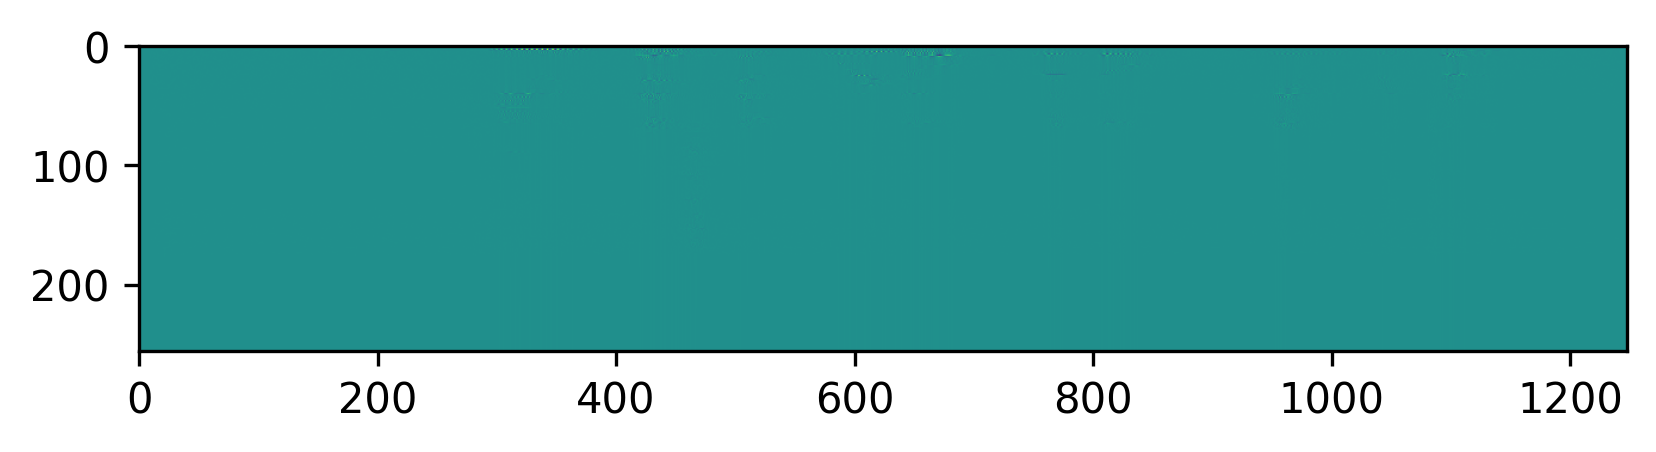

In [354]:
plt.figure(dpi=300)
plt.imshow(x[0][:,:,0])

In [158]:
x[0].std()

tensor(68139.3828)

In [356]:
def makemanyrandsum(num):
    return [L(getrandsum())for _ in range(num)]

### 生成数据集

由于fastai的文本说数据块是可以调整的

所以应当可以修改数据块

In [554]:
dl = DataBlock(
    get_items=makemanyrandsum,
    get_x=(lambda x:x[1]),
    get_y=(lambda x:x[0])
)

In [639]:
dls = dl.dataloaders(32,bs=1)

In [556]:
dls.dataset[0][0].shape

torch.Size([256, 1184, 2])

### 定义模型

一个简单的神经网络

也就是:  
识别噪音 -> 产生掩码 -> 相乘

那么大概率需要一个UNet

In [557]:
class Decoder(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(Decoder, self).__init__()
        
        self.up = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv_relu = nn.Sequential(
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        
        x1 = self.up(x1)
        # print(x1.shape,x2.shape)
        x1 = torch.cat((x1, x2), dim=1)
        x1 = self.conv_relu(x1)
        return x1

In [558]:
import torchvision

注意:下采样时需要使输出为偶数尺寸  
尼玛的

In [671]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.base_model = torchvision.models.resnet18(True)  # 不使用预训练模型
        self.base_layers = list(self.base_model.children())

        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(  # 数据有两个通道
                2, 2), padding=(3, 3), bias=False),
            self.base_layers[1],
            self.base_layers[2])
        
        self.layer2 = nn.Sequential(*self.base_layers[3:5])
        self.layer3 = self.base_layers[5]
        self.layer4 = self.base_layers[6]
        self.layer5 = self.base_layers[7]

        self.decode4 = Decoder(512, 256+256, 256)
        self.decode3 = Decoder(256, 256+128, 256)
        self.decode2 = Decoder(256, 128+64, 128)
        self.decode1 = Decoder(128, 64+64, 64)

        self.decode0 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        )

        self.conv_last = nn.Conv2d(64, 2, 1)  # 这边转换为二通道数据

    def forward(self, inp):
        # 输入: 1,257,1251,2

        inp = inp.permute(0, 3, 1, 2)  # 输入: 1,2,257,1251
        
        e1 = self.layer1(inp)  # 64,128,128
        e2 = self.layer2(e1)  # 64,64,64
        e3 = self.layer3(e2)  # 128,32,32
        e4 = self.layer4(e3)  # 256,16,16
        # print(inp.shape)
        # print('e1',e1.shape)
        # print('e2',e2.shape)
        # print('e3',e3.shape)
        # print('e4',e4.shape)
        f = self.layer5(e4)  # 512,8,8
        # print(f.shape)
        d4 = self.decode4(f, e4)  # 256,16,16
        d3 = self.decode3(d4, e3)  # 256,32,32
        d2 = self.decode2(d3, e2)  # 128,64,64
        d1 = self.decode1(d2, e1)  # 64,128,128
        d0 = self.decode0(d1)  # 64,256,256

        out = self.conv_last(d0)  # 1,256,256
        out = F.relu(out)
        out = inp*out*2
        
        out = out.permute(0, 2, 3, 1)
        
        return out

In [672]:
m = Unet()

/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 训练

In [679]:
learn = Learner(dls,
               m,
               loss_func=MSELossFlat())

SuggestedLRs(valley=7.585775892948732e-05)

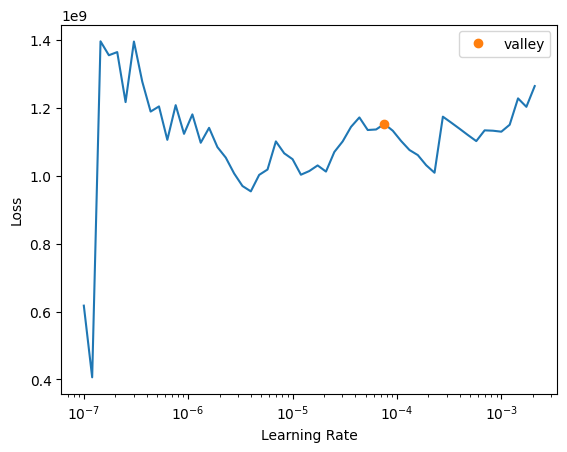

In [684]:
learn.lr_find()

In [685]:
learn.fit_one_cycle(20,lr_max=1e-4,wd=0.1)

epoch,train_loss,valid_loss,time
0,1063987328.000000,1499405184.000000,00:03
1,1035659392.000000,1505670016.000000,00:03
2,1029739520.000000,1915038336.000000,00:03
3,1021275200.000000,1110048768.000000,00:03
4,969371776.000000,1299604992.000000,00:03
5,1188526720.000000,2481841152.000000,00:03
6,1203985408.000000,1022094656.000000,00:03
7,1062659456.000000,1174340352.000000,00:03
8,935242432.000000,1299622272.000000,00:03
9,849982976.000000,839617472.000000,00:03


In [526]:
learn.freeze()

In [527]:
learn.unfreeze()

可以使用

In [640]:
m = learn.model

## 查看结果

In [694]:
x=m(dls.valid.one_batch()[0].cuda())

In [695]:
y1 = torch.istft(x[0], 511).cpu().detach()

In [696]:
y = x.cpu().detach()

In [697]:
y.shape

torch.Size([1, 256, 1024, 2])

In [705]:
y2 = torch.istft(dls.valid.one_batch()[1][0], 511).cpu()

In [706]:
y3 = torch.istft(dls.valid.one_batch()[0][0], 511).cpu()

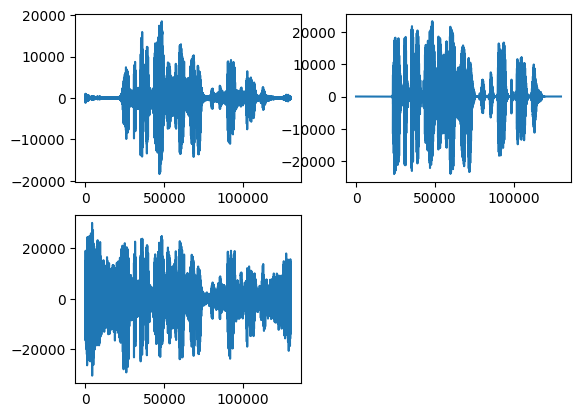

In [721]:
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax1.plot(y1)
ax2.plot(y2)
ax3.plot(y3)

听听看

In [719]:
playarr(y2)

In [718]:
playarr(y3)

In [720]:
playarr(y1)

效果好像还可以哦

### 保存

In [730]:
learn.save('learn.pth')

Path('models/learn.pth.pth')

定义一个返回所有原始数据的函数

In [116]:
def getrandsum2(vset0=voiceset,vset1=voiceset2):
    i = random.randint(0,len(vset0)-1)
    j = random.randint(0,len(vset1)-1)
    
    arr0 = getmp3raw(vset0[i])
    arr1 = getwavraw(vset1[j])
    
    arr0,arr1,arr2 = getsumvoice(arr0,arr1)
    
    arr0 = tensor(arr0.copy()).float().reshape(-1,1)
    arr2 = tensor(arr2.copy()).float().reshape(-1,1)
    
    m = torch.abs(arr2).max()
    
    return arr2,arr0,m,arr1

In [117]:
arr2,arr0,m,arr1 = getrandsum2()

pred = learn.predict(arr2/m)[0]*m

targ = arr0

nois = arr1

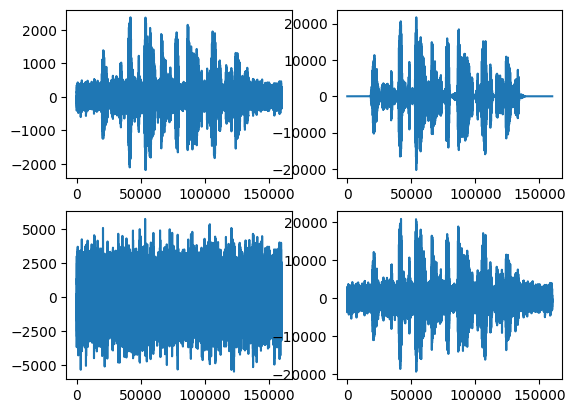

In [118]:
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
ax1.plot(np.arange(len(pred)),pred)
ax2.plot(np.arange(len(pred)),targ)
ax3.plot(np.arange(len(pred)),nois)
ax4.plot(np.arange(len(pred)),arr2)

In [121]:
arr =array(targ)
#arr = arr.reshape(-1)
arr.dtype='int16'

playarr(arr,32000)

In [865]:
arr = getmp3raw(voiceset[129])

In [866]:
playarr(arr)

In [867]:
arr.shape

(199296,)

In [880]:
arr.dtype = 'int16'

In [882]:
arr1 = tensor(arr).half()

In [884]:
arr1.shape

torch.Size([199296])

In [885]:
len(arr1.reshape(-1))

199296

In [886]:
arr =array(arr1)
arr = arr.reshape(-1)
arr.dtype='int16'

In [887]:
len(arr)

199296

In [888]:
playarr(arr,32000)

### 音频转换测试

奇怪的事情,转化为float再转化回来会使音频损坏

In [64]:
arr = getmp3raw(voiceset[129])

In [65]:
arr.shape

(199296,)

In [67]:
arr1 = tensor(arr.copy())

In [68]:
arr1.shape

torch.Size([199296])

In [88]:
arr2 = arr1.float()

In [89]:
len(arr2)

199296

In [105]:
arr3 = arr2*2

In [106]:
arr3 = arr3.reshape(-1,1)/2

In [107]:
len(arr3)

199296

In [108]:
arr4 = array(arr3,dtype='int16')

In [109]:
len(arr4)

199296

In [112]:
playarr(arr4,32000)

In [132]:
arr2

tensor([[-1718.],
        [-1553.],
        [ -658.],
        ...,
        [  467.],
        [ -265.],
        [ -902.]])

In [191]:
k = torch.stft(arr2.reshape(-1),512)

In [192]:
k.shape

torch.Size([257, 1251, 2])

In [197]:
k[1,:,0].shape

torch.Size([1251])

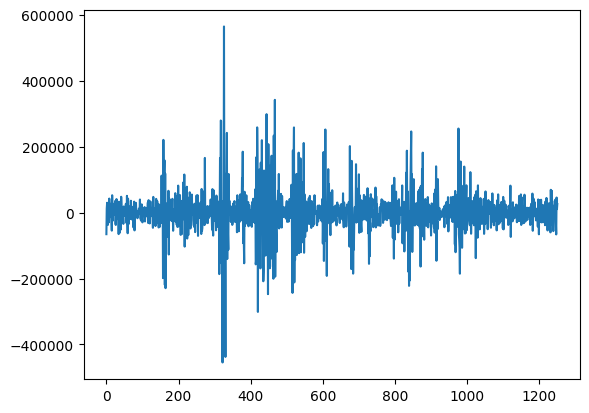

In [205]:
plt.plot(np.arange(1251),k[1,:,0])

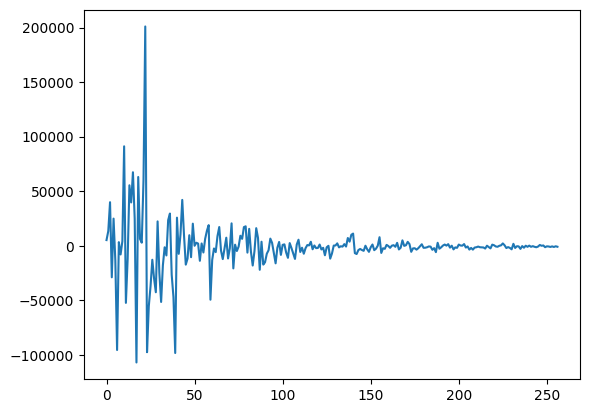

In [214]:
plt.plot(np.arange(257),k[:,9,0])

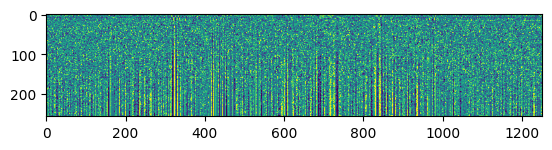

In [225]:
plt.imshow(torch.tanh(k[:,:,0]))

In [222]:
torch.istft(k,512)

tensor([-1718.0000, -1553.0004,  -657.9999,  ...,   467.0001,  -265.0000,
         -901.9998])